The wavelet transform is implemented in pywt and can be called as follows.

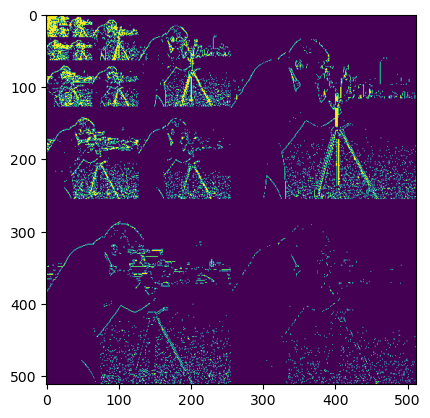

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

mode = 'periodization'
wavelet_type = 'haar'
level = 9
cam = pywt.data.camera()/255

#decompose and reconstruct wavelet coefficients like this:
coeffs = pywt.wavedecn(cam, wavelet=wavelet_type,mode=mode,level=level) # perform discrete wavelet transform
im = pywt.waverecn(coeffs, wavelet=wavelet_type, mode=mode)

#convert coefficients to array
arr, coeff_slices = pywt.coeffs_to_array(coeffs) 
plt.imshow(np.abs(arr)>0.1) #visualise the coefficients, I display only the 'larger' coefficients


Exercise: set 95% of the smallest coefficients to zero and display the reconstruction from the 'truncated coefficients'. 

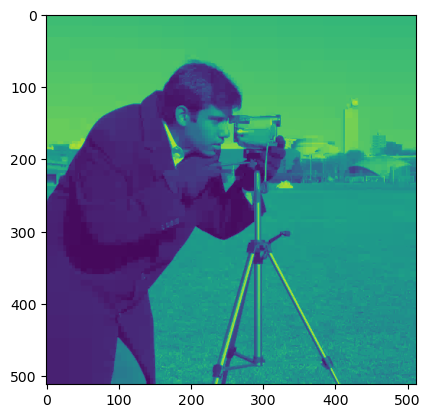

In [2]:

#compute the wavelet coefficients
coeffs = pywt.wavedecn(cam, wavelet=wavelet_type,mode=mode, level=level) # perform discrete wavelet transform
coeffs_1d, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs) #reshape the coefficients as a vector for easier handling


# set the smallest k coefficients (in abs value) to 0
K = len(coeffs_1d)
k = K*95//100
idx = np.argpartition(np.abs(coeffs_1d), k)
coeffs_1d[idx[:k]] = 0

#reconstruct from truncated wavelet coefficients
coeffs_rec = pywt.unravel_coeffs(coeffs_1d, coeff_slices, coeff_shapes)
im = pywt.waverecn(coeffs_rec, wavelet=wavelet_type, mode=mode)

plt.imshow(im)

The following code defines the forward and inverse wavelet transform such that py_W maps images to a vector of wavelet coefficients and py_Ws reconstructs an images from a vector of wavelet coefficients. 

Exercise: Check that these transforms are adjoint and inverses to each other.

In [3]:
def getWaveletTransforms(n,m,wavelet_type = "db2",level = 5):
    mode = "periodization"

    
    coeffs_tpl = pywt.wavedecn(data=np.zeros((n, m)), wavelet=wavelet_type, mode=mode, level=level)
    coeffs_1d, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs_tpl)
    coeffs_tpl_rec = pywt.unravel_coeffs(coeffs_1d, coeff_slices, coeff_shapes)

    def py_W(im):
        alpha = pywt.wavedecn(data=im, wavelet=wavelet_type, mode=mode, level=level)
        alpha, _, _ = pywt.ravel_coeffs(alpha)
        return alpha

    def py_Ws(alpha):
        coeffs = pywt.unravel_coeffs(alpha, coeff_slices, coeff_shapes)
        im = pywt.waverecn(coeffs, wavelet=wavelet_type, mode=mode)
        return im
    
    return py_W, py_Ws

n,m = 512,512
py_W, py_Ws = getWaveletTransforms(n,m,wavelet_type = "db2")

y_example = np.random.rand(n, m)
x_example = py_W(np.random.rand(n,m))
print("Adjoint:")
x_Tadj_y = np.dot(x_example, np.conjugate(py_W(y_example)))
T_x_y = np.dot(py_Ws(x_example).flatten(), np.conjugate(y_example.flatten()))
print(np.allclose(x_Tadj_y, T_x_y))
print("\n Inverse from image to image:")
print(np.allclose(py_Ws(py_W(y_example)), y_example))
print("\n Inverse from coefficients to coefficients:")
print(np.allclose(py_W(py_Ws(x_example)), x_example))

Adjoint:
True

 Inverse from image to image:
True

 Inverse from coefficients to coefficients:
True


We will now consider the inverse problem of deconvolution. Define the deconvolution operator $\Phi u = h\star u$ using the Fourier transform.

In [4]:
from numpy.fft import fft2, ifft2
# define filter
def GaussianFilter(s,n,m): 
    x = np.hstack((np.arange(0,n//2), np.arange(-n//2,0)))
    y = np.hstack((np.arange(0,m//2), np.arange(-m//2,0)))
    [X,Y] = np.meshgrid(y,x)
    h = np.exp( (-X**2-Y**2)/(2*s**2) )
    h = h/sum(sum(h))
    return h


cam = pywt.data.camera()/255
n,m = cam.shape


s = 4
h = GaussianFilter(s,n,m)
Phi = lambda x: np.real(ifft2(fft2(x)*fft2(h))); 
Phi_s = lambda x: np.real(ifft2(fft2(x)*np.conjugate(fft2(h))))

# mask = np.zeros((n,m))
# mask[:n//8,:m//8]+=1
# mask[7*n//8:,7*m//8:]+=1

# mask[np.random.permutation(n*m)[:ceil(n*m*0.2)]] = np.ones(ceil(n*m*0.2))
# Phi = lambda x: np.concatenate(np.real(mask*fft2(x)), np.imag(mask*fft2(x)))/np.sqrt(n*m)
# Phi_s = lambda x: ifft2(mask*(x))*np.sqrt(n*m)


Display $f =\Phi u + w$ where $u$ is the camera image and $s$ is some random Gaussian noise.



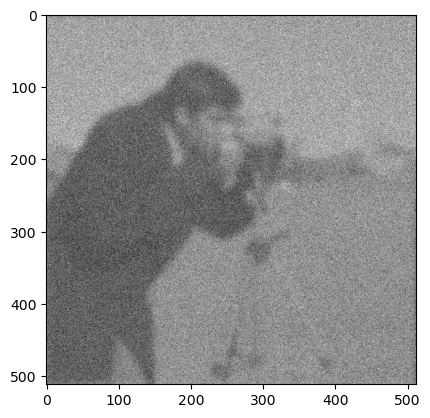

In [5]:
from skimage.util import random_noise
import matplotlib.pyplot as plt
b = Phi(cam)

# add noise
sigma = .05;
b = random_noise(b,mode='gaussian',var=sigma,clip=False)

plt.imshow(b, cmap="gray")

plt.show()


We will consider the regularisation
$$
R_\alpha(f)  := \mathrm{argmin}_u \frac12 \| \Phi u - f\|^2 + \alpha\|W u\|_1
$$
where $W$ is the discrete wavelet transform. Note that since $W^* = W^{-1}$, we can rewrite this as $R_\alpha(f) = W^* z_\alpha$ where
$$
z_\alpha  := \mathrm{argmin}_z \frac12 \| A z - f\|^2 + \alpha\|z\|_1.
$$
where $A:= \Phi\circ W^*$.


**Exercise:** Implement the proximal gradient descent algorithm to compute the wavelet regularised solutions to the deconvolution problem.

In [6]:
def rFISTA(proxF, dG, gamma, xinit,niter,mfunc):
    tol = 1e-16

    x = xinit
    z = x
    t=1
    fval = []
    for k in range(niter):
        xkm = x
        ykm =z

        x =  proxF( z - gamma*dG(z), gamma )
        tnew = (1+np.sqrt(1+4*t**2))/2

        z = x + (t-1)/(tnew)*(x-xkm)
        t = tnew
        if np.sum((ykm-x)*(x-xkm))>0:
            z=x;
        fval.append(mfunc(x))

        if np.linalg.norm(xkm-x)<tol:
            break
    return x, fval
        
def ISTA(proxF, dG, gamma, xinit,niter,mfunc):
    x = xinit
    
    fval = []
    for k in range(niter):
        x =  proxF( x - gamma*dG(x), gamma )
        fval.append(mfunc(x))

    return x, fval

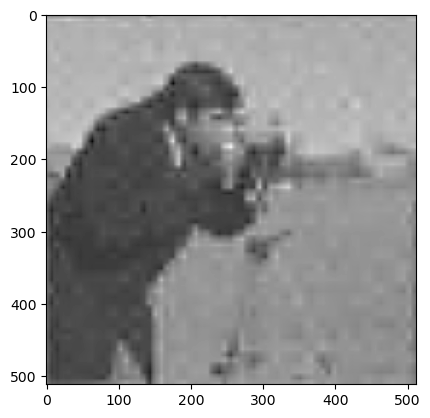

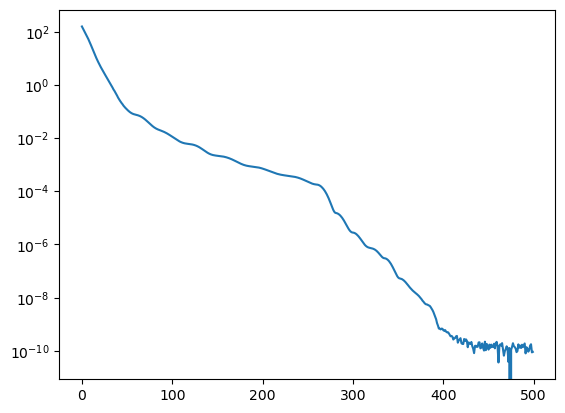

In [7]:
#define the operator A
py_W, py_Ws = getWaveletTransforms(n,m,wavelet_type = "db2",level = 4)

# Phi o W^{-1}
A = lambda coeffs: Phi(py_Ws(coeffs))

# W o Phi 
As = lambda im: py_W(Phi_s(im))


prox = lambda x, tau: np.maximum(np.abs(x)-tau, np.zeros_like(x))*np.sign(x)

alpha = .2
mfunc = lambda x: .5* np.linalg.norm(A(x)-b,ord='fro')**2 + alpha*np.linalg.norm(x,ord=1)


tau = 1/20
nIter =500
dG = lambda x: As(A(x) - b)
proxF = lambda x,tau: prox(x,tau*alpha)
xinit = As(b)
x,fval = rFISTA(proxF, dG, tau, xinit,nIter,mfunc)
plt.imshow(py_Ws(x), cmap="gray")

plt.show()

plt.semilogy(fval-min(fval))